In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from glob import glob
import cv2
from sklearn.model_selection import train_test_split



print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 37.3 MB/s eta 0:00:00


In [4]:
# connext to archive folder in drive
from google.colab import drive
drive.mount('/content/drive')
#https://drive.google.com/drive/folders/1_cack_LaBZwMP5SsSvG_f9y7xzKmeTlo?usp=share_link

Mounted at /content/drive


In [5]:
# Adding Salt and Pepper noise to an image
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """
    Add Salt and Pepper noise to an image.

    :param image: Input image (numpy array)
    :param salt_prob: Probability of adding salt noise (white pixels)
    :param pepper_prob: Probability of adding pepper noise (black pixels)
    :return: Noisy image with Salt and Pepper noise
    """
    noisy_image = np.copy(image)

    # Salt noise (white pixels)
    num_salt = np.ceil(salt_prob * image.size).astype(int)
    coords_salt = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords_salt[0], coords_salt[1], :] = 255

    # Pepper noise (black pixels)
    num_pepper = np.ceil(pepper_prob * image.size).astype(int)
    coords_pepper = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords_pepper[0], coords_pepper[1], :] = 0

    return noisy_image

In [6]:
#dataset_path = 'archive'
dataset_path = '/content/drive/MyDrive/archive'

In [7]:
import re

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0


print(the_number_in_the_string("file123.txt"))
print(the_number_in_the_string("no_numbers"))

123
0


In [8]:
#to store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)
labels_dict


{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_w': [],
 'img_h': []}

In [9]:
import os
from glob import glob

#get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
xml_files

['/content/drive/MyDrive/archive/annotations/Cars1.xml',
 '/content/drive/MyDrive/archive/annotations/Cars0.xml',
 '/content/drive/MyDrive/archive/annotations/Cars103.xml',
 '/content/drive/MyDrive/archive/annotations/Cars107.xml',
 '/content/drive/MyDrive/archive/annotations/Cars105.xml',
 '/content/drive/MyDrive/archive/annotations/Cars102.xml',
 '/content/drive/MyDrive/archive/annotations/Cars10.xml',
 '/content/drive/MyDrive/archive/annotations/Cars104.xml',
 '/content/drive/MyDrive/archive/annotations/Cars100.xml',
 '/content/drive/MyDrive/archive/annotations/Cars106.xml',
 '/content/drive/MyDrive/archive/annotations/Cars101.xml',
 '/content/drive/MyDrive/archive/annotations/Cars239.xml',
 '/content/drive/MyDrive/archive/annotations/Cars248.xml',
 '/content/drive/MyDrive/archive/annotations/Cars21.xml',
 '/content/drive/MyDrive/archive/annotations/Cars157.xml',
 '/content/drive/MyDrive/archive/annotations/Cars297.xml',
 '/content/drive/MyDrive/archive/annotations/Cars64.xml',
 '/c

In [10]:

import xml.etree.ElementTree as xet
import cv2
for key, value in labels_dict.items():
    print(f'Length of {key}: {len(value)}')

Length of img_path: 0
Length of xmin: 0
Length of xmax: 0
Length of ymin: 0
Length of ymax: 0
Length of img_w: 0
Length of img_h: 0


In [11]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as xet

# Initialize the dictionary before the loop
labels_dict = {
    'img_path': [],
    'xmin': [],
    'xmax': [],
    'ymin': [],
    'ymax': [],
    'img_w': [],
    'img_h': []
}

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    try:
        # Parse the XML file
        info = xet.parse(filename)
        root = info.getroot()

        # Finding bounding box info
        member_object = root.find('object')
        if member_object is not None:
            labels_info = member_object.find('bndbox')
            xmin = int(labels_info.find('xmin').text)
            xmax = int(labels_info.find('xmax').text)
            ymin = int(labels_info.find('ymin').text)
            ymax = int(labels_info.find('ymax').text)
        else:
            # Skip if 'object' or bounding box information is missing
            continue

        # Join full path for the image
        img_name = root.find('filename').text
        img_path = os.path.join(dataset_path, 'images', img_name)

        # Read image and get dimensions
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
        else:
            # Skip if the image file is missing or cannot be read
            print(f"Image not found or unreadable: {img_path}")
            continue

        # Add to dictionary
        labels_dict['img_path'].append(img_path)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
        labels_dict['img_w'].append(width)
        labels_dict['img_h'].append(height)

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Show the result
print(alldata.head())


                                          img_path  xmin  xmax  ymin  ymax  \
0  /content/drive/MyDrive/archive/images/Cars0.png   226   419   125   173   
1  /content/drive/MyDrive/archive/images/Cars1.png   134   262   128   160   
2  /content/drive/MyDrive/archive/images/Cars2.png   229   270   176   193   
3  /content/drive/MyDrive/archive/images/Cars3.png   142   261   128   157   
4  /content/drive/MyDrive/archive/images/Cars4.png   156   503    82   253   

   img_w  img_h  
0    500    268  
1    400    248  
2    400    400  
3    400    225  
4    590    350  


In [12]:
from sklearn.model_selection import train_test_split

# train test val split
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



In [13]:
import shutil

# remove if exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [23]:
# Define the path in Google Drive where Gaussian images will be saved
drive_salt_and_pepper_image_path = '/content/drive/MyDrive/salt_and_pepper_images'

# Function to make split folder in YOLO format with Gaussian noise
def make_split_folder_with_noise(split_name, split_df, apply_noise=False):
    labels_path = os.path.join(drive_salt_and_pepper_image_path, split_name, 'labels')
    images_path = os.path.join(drive_salt_and_pepper_image_path, split_name, 'images')

    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save labels in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Load image and add Gaussian noise
        img = cv2.imread(row['img_path'])
        if apply_noise:
            img = add_salt_and_pepper_noise(img)

        # Save the noisy image
        cv2.imwrite(os.path.join(images_path, img_name + img_extension), img)

    print(f"Created '{images_path}' and '{labels_path}'")

In [24]:
make_split_folder_with_noise('train', train, apply_noise=True)
make_split_folder_with_noise('val', val, apply_noise=True)
make_split_folder_with_noise('test', test, apply_noise=True)

Created '/content/drive/MyDrive/salt_and_pepper_images/train/images' and '/content/drive/MyDrive/salt_and_pepper_images/train/labels'
Created '/content/drive/MyDrive/salt_and_pepper_images/val/images' and '/content/drive/MyDrive/salt_and_pepper_images/val/labels'
Created '/content/drive/MyDrive/salt_and_pepper_images/test/images' and '/content/drive/MyDrive/salt_and_pepper_images/test/labels'


In [25]:
os.getcwd()

'/content'

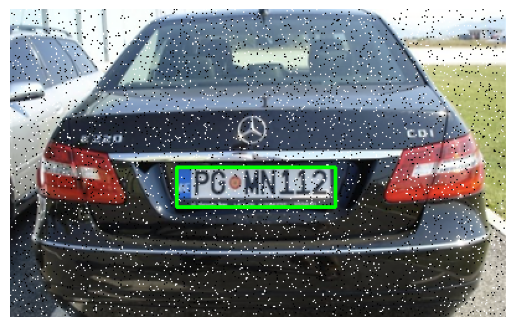

In [26]:
image_dir = '/content/drive/MyDrive/salt_and_pepper_images/train/images'

label_dir = '/content/drive/MyDrive/salt_and_pepper_images/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

# Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height


    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [41]:
# Datasets YAML configuration
datasets_yaml = '''
path: /content/drive/MyDrive/salt_and_pepper_images

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''


# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)


In [40]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [39]:
os.environ['WANDB_MODE'] = 'offline'

In [44]:
# Use a simple folder name for the project, not the full path
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True,
    project='yolo_results',  # Specify a valid folder name
    name='salt_and_pepper_noisy_model',  # Specify the name for the training run
)

Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=yolo_results, name=salt_and_pepper_noisy_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 155MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/salt_and_pepper_images/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:03<00:00, 94.90it/s] 


train: New cache created: /content/drive/MyDrive/salt_and_pepper_images/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:04<00:00, 82.28it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/salt_and_pepper_images/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 87.62it/s]

val: New cache created: /content/drive/MyDrive/salt_and_pepper_images/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 105.74it/s]


Plotting labels to yolo_results/salt_and_pepper_noisy_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to yolo_results/salt_and_pepper_noisy_model
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.646G      1.832      3.026      1.386         19        320: 100%|██████████| 22/22 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         44         44    0.00376      0.932       0.37      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.621G      1.626      1.751      1.138         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         44         44          1      0.106      0.247       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.633G        1.6       1.48      1.222         23        320: 100%|██████████| 22/22 [00:02<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]

                   all         44         44      0.486      0.108      0.175     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.623G      1.626      1.422      1.236         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         44         44      0.741      0.261      0.543      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.623G      1.559      1.375       1.19         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

                   all         44         44      0.804        0.5        0.6      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.631G      1.578      1.263      1.194         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]

                   all         44         44      0.605      0.558      0.562      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.623G      1.543      1.178      1.203         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         44         44      0.818       0.75      0.812      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.631G      1.511      1.177      1.178         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]

                   all         44         44      0.764      0.773      0.774      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.623G      1.419      1.105      1.153         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         44         44      0.686      0.568      0.618      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.631G       1.48      1.119      1.142         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         44         44      0.757      0.705      0.774      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.623G      1.382       1.06      1.116         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]

                   all         44         44      0.707      0.682      0.702      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.631G      1.461      1.088      1.171         21        320: 100%|██████████| 22/22 [00:03<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

                   all         44         44      0.921       0.75      0.839      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.623G      1.469       1.03       1.14         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         44         44      0.768      0.773      0.812      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.631G      1.446          1      1.134         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         44         44      0.883      0.636      0.761      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.623G      1.333     0.9335      1.097         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         44         44      0.711      0.705      0.771      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.631G      1.356     0.9286      1.112         13        320: 100%|██████████| 22/22 [00:02<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         44         44      0.874      0.864      0.915      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.623G      1.339     0.9022      1.116         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

                   all         44         44      0.843      0.735      0.838      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.631G      1.259     0.8598       1.08         21        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

                   all         44         44      0.923      0.773      0.862      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.623G      1.298     0.8472      1.089         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


                   all         44         44      0.913      0.795      0.856      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.631G      1.289     0.8336      1.087         24        320: 100%|██████████| 22/22 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         44         44       0.95      0.862        0.9      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.623G       1.24     0.8127      1.071         21        320: 100%|██████████| 22/22 [00:03<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         44         44      0.966       0.75      0.866       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.631G      1.291     0.8466      1.093         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         44         44      0.873      0.864      0.874      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.623G      1.286     0.8441       1.09         14        320: 100%|██████████| 22/22 [00:02<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         44         44      0.911      0.841      0.872      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.631G      1.246       0.79      1.078         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         44         44      0.897      0.792       0.86      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.621G      1.257     0.7901      1.056         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.939       0.75      0.826      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.629G      1.243     0.7876      1.066         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.06it/s]

                   all         44         44      0.901      0.795      0.855      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.623G      1.204     0.7599      1.051         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         44         44      0.871      0.818      0.855      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.631G      1.185      0.753       1.04         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]

                   all         44         44      0.849      0.818      0.869       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.623G      1.155     0.7283      1.052         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]

                   all         44         44      0.922       0.81      0.886      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.631G      1.171     0.7463      1.031         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         44         44      0.917      0.841      0.882      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.623G       1.15     0.7239      1.021         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         44         44      0.837      0.886      0.882      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.631G       1.15     0.7313      1.019         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]

                   all         44         44      0.878      0.864      0.873      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.623G      1.225     0.7506       1.06         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]

                   all         44         44      0.873      0.818      0.871      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.631G      1.096      0.712      1.022         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         44         44      0.851      0.778      0.865      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.621G      1.082     0.6805      1.011         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         44         44      0.908      0.795      0.888      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.631G      1.129      0.705      1.024         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


                   all         44         44       0.94      0.795      0.887      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.623G      1.109     0.6972      1.025         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


                   all         44         44      0.955      0.773      0.871       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.631G      1.118     0.6983      1.012         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         44         44      0.903      0.864      0.888      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.623G      1.118     0.7054      1.014         20        320: 100%|██████████| 22/22 [00:02<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         44         44      0.883      0.864      0.897       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.631G      1.107     0.6599      1.011         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


                   all         44         44      0.923      0.864      0.894      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.623G      1.103      0.684      1.018         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         44         44      0.828      0.874      0.888      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.629G      1.054     0.6578      1.007         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         44         44       0.95      0.818      0.896      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.623G      1.076     0.6585      1.005         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all         44         44      0.902      0.839      0.885       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.631G      1.097     0.6711      0.993         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         44         44      0.973      0.831      0.892      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.623G      1.054     0.6685     0.9879         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]

                   all         44         44      0.917      0.841      0.879      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.631G      1.047     0.6422      1.003         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


                   all         44         44      0.901      0.832      0.881      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.623G      1.054     0.6594     0.9841         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         44         44      0.862      0.849      0.862      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.631G      1.023     0.6393     0.9735         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.01it/s]

                   all         44         44      0.909      0.795      0.868      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.623G     0.9884      0.615     0.9718         12        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         44         44      0.919      0.774      0.879      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.631G      1.063     0.6457     0.9909         15        320: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.897       0.79      0.883      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.623G      1.022      0.626     0.9933         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]

                   all         44         44      0.895      0.795      0.883        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.631G      1.033     0.6141     0.9931         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44      0.868      0.886      0.887      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.623G      1.015     0.5982      0.972         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         44         44      0.908      0.897      0.906      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.631G      0.974      0.588     0.9722         23        320: 100%|██████████| 22/22 [00:03<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]

                   all         44         44       0.86      0.818       0.87      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.621G     0.9887      0.626     0.9839         10        320: 100%|██████████| 22/22 [00:02<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         44         44      0.877      0.818       0.87       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.631G     0.9818     0.6099     0.9643         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

                   all         44         44       0.88      0.818      0.891      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.621G     0.9704     0.5923     0.9707         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         44         44      0.946      0.795      0.884      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.631G     0.9729     0.5996     0.9568         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         44         44      0.944      0.773      0.896      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.621G     0.9775      0.582     0.9586         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]

                   all         44         44       0.83      0.864      0.899      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.631G     0.9534     0.5835     0.9682         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


                   all         44         44      0.925      0.795      0.855      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.623G     0.9705     0.5733     0.9692         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         44         44       0.84      0.864      0.868      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.631G     0.9177     0.5619      0.955         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         44         44      0.876      0.841      0.869      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.621G     0.8897     0.5547     0.9603          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


                   all         44         44      0.913      0.818      0.872       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.631G     0.9038     0.5535     0.9559         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44      0.973      0.811      0.895      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.623G     0.9358     0.5685     0.9518         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         44         44      0.931      0.795      0.876      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.631G     0.8922     0.5361     0.9457         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

                   all         44         44      0.834      0.841      0.847      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.621G     0.8889      0.551     0.9349         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all         44         44      0.826       0.86      0.839      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.631G     0.8786     0.5345     0.9231         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         44         44      0.839      0.886      0.889      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.623G      0.855     0.5391     0.9356         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]

                   all         44         44      0.879      0.864      0.892      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.631G      0.853     0.5048     0.9337         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         44         44      0.885      0.909      0.918      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.623G     0.8847     0.5437     0.9283         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         44         44      0.883      0.886      0.885      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.631G     0.9006     0.5299     0.9446         15        320: 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         44         44      0.909      0.864      0.897      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.623G      0.886     0.5359      0.935         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]

                   all         44         44      0.899      0.886      0.888      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.629G     0.8798      0.524     0.9302         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

                   all         44         44      0.896      0.886      0.899      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.623G     0.8643     0.5236     0.9432         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         44         44      0.878      0.841      0.877      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.631G     0.8262     0.5291     0.9289         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]

                   all         44         44      0.879      0.824      0.876      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.623G     0.8254     0.5022     0.9208         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]

                   all         44         44      0.889      0.907      0.892      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.631G     0.8479      0.516     0.9238         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


                   all         44         44      0.904      0.856      0.879      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.623G     0.8437     0.5121      0.938         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         44         44       0.88      0.837      0.872      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.631G     0.8474     0.5102     0.9336         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         44         44      0.904      0.858      0.872      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.623G     0.8029     0.4938     0.9205         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]

                   all         44         44       0.88      0.864      0.876      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.631G     0.8192     0.4942     0.9199         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         44         44      0.901      0.826      0.864      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.623G      0.801     0.4701     0.9182         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         44         44      0.894      0.841      0.882      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.631G     0.7849     0.4693     0.9054         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         44         44      0.896      0.818      0.881       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.623G     0.8143     0.4818     0.9177         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         44         44      0.889      0.795      0.867      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.631G     0.8099     0.4921     0.9196         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.863      0.861      0.871      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.623G     0.7852     0.4904     0.9094         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         44         44      0.861      0.864      0.879      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.631G     0.7932     0.4854      0.926         14        320: 100%|██████████| 22/22 [00:02<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.883       0.86      0.884      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.623G     0.7798     0.4643     0.9178         21        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         44         44      0.924      0.825      0.878      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.631G     0.7882     0.4658     0.9156         15        320: 100%|██████████| 22/22 [00:03<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


                   all         44         44      0.882      0.864      0.889      0.524
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.621G      1.033     0.5609       1.01          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         44         44      0.907      0.818      0.887      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.629G      1.033     0.5519      1.018          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all         44         44      0.909      0.795      0.874      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.621G      1.008     0.5394     0.9993          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         44         44      0.879      0.841      0.878      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.629G     0.9767     0.5231     0.9797          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.53it/s]

                   all         44         44      0.884      0.863      0.877      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.621G      0.996     0.5096      1.003          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

                   all         44         44      0.954      0.795      0.893      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.629G      1.002     0.5302     0.9983          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]

                   all         44         44      0.866      0.881      0.882      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.621G     0.9777     0.4945     0.9785          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

                   all         44         44      0.925      0.837      0.882      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.629G     0.9532     0.5262     0.9634          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         44         44      0.866       0.88      0.882      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.621G     0.9354      0.501     0.9704          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         44         44      0.924      0.833      0.884      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.631G     0.9454     0.5028     0.9711          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         44         44      0.925       0.84      0.884      0.525



100 epochs completed in 0.124 hours.
Optimizer stripped from yolo_results/salt_and_pepper_noisy_model/weights/last.pt, 6.2MB
Optimizer stripped from yolo_results/salt_and_pepper_noisy_model/weights/best.pt, 6.2MB

Validating yolo_results/salt_and_pepper_noisy_model/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


                   all         44         44      0.883       0.86      0.885      0.539
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to yolo_results/salt_and_pepper_noisy_model


lr/pg0,▄▆████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁
lr/pg1,▂▄▆██▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
lr/pg2,▂▆██▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▄▆▇▆▇▇▇▇█████▇█████████▇██████▇█▇██████
metrics/mAP50-95(B),▁▃▅▅▄▅▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇███▇█
metrics/precision(B),▁▄▇▅▆▆█▇███▇█▇█▇██▇█▇█▇█▇▇▇██▇▇█▇▇█▇▇▇▇█
metrics/recall(B),▁▁▅▆▇▆▇▇▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇██████▇▇▇██▇█▇█▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▇▆▅▆▅▆▅▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▃▂▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb299273cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [45]:
import shutil

# Define the source and destination paths
source_path = '/content/yolo_results/salt_and_pepper_noisy_model'
destination_path = '/content/drive/MyDrive/salt_and_pepper_images/yolo_training_results'

# Move the folder to Google Drive
shutil.move(source_path, destination_path)

print(f"Training results moved to {destination_path}")


Training results moved to /content/drive/MyDrive/salt_and_pepper_images/yolo_training_results


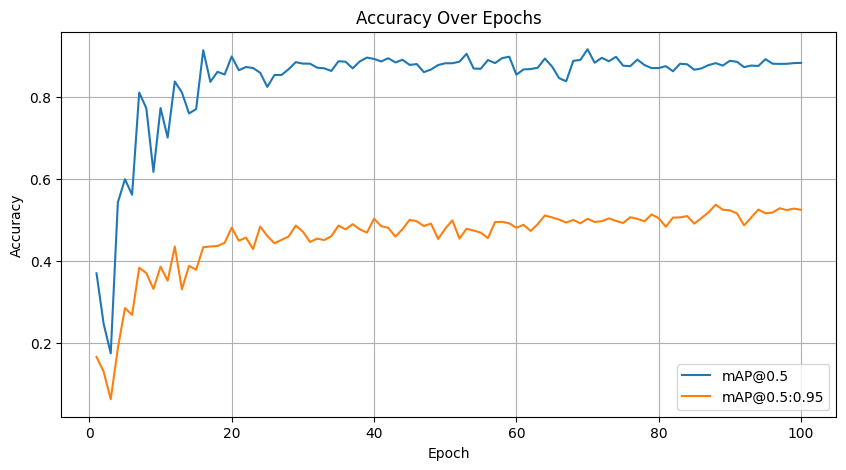

In [47]:
# Get the path of the log directory in Google Drive
log_dir = max(glob(f'/content/drive/MyDrive/salt_and_pepper_images/yolo_training_results*'), key=os.path.getctime)

# Read the training results from the saved CSV in Google Drive
results_csv_path = os.path.join(log_dir, 'results.csv')
results = pd.read_csv(results_csv_path)
results.columns = results.columns.str.strip()

# Extract epochs and mAP metrics
epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# Save the trained model in Google Drive
model.save('/content/drive/MyDrive/salt_and_pepper_images/license_plate_model_with_salt_and_pepper_noise.pt')

In [49]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 /content/drive/MyDrive/Gaussian_images/val/images/Cars0.png: 192x320 1 license_plate, 52.2ms
Speed: 1.2ms preprocess, 52.2ms inference, 21.3ms postprocess per image at shape (1, 3, 192, 320)


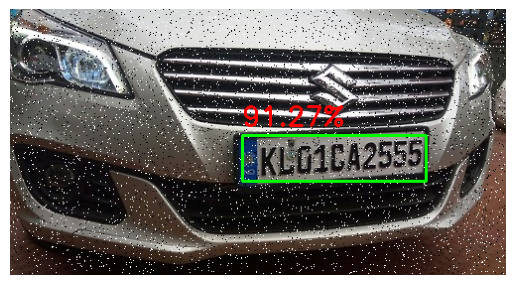

In [50]:
predict_and_plot('/content/drive/MyDrive/Gaussian_images/val/images/Cars0.png')


image 1/1 /content/drive/MyDrive/Gaussian_images/val/images/Cars106.png: 224x320 2 license_plates, 67.4ms
Speed: 1.1ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


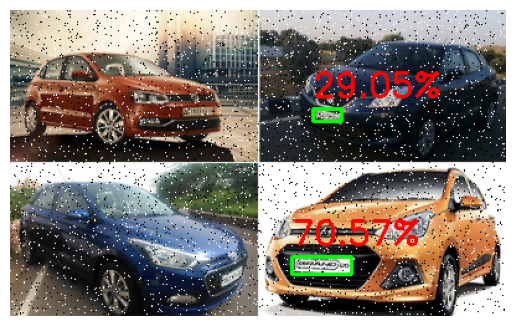

In [51]:
predict_and_plot('/content/drive/MyDrive/Gaussian_images/val/images/Cars106.png')


image 1/1 /content/drive/MyDrive/Gaussian_images/val/images/Cars182.png: 192x320 1 license_plate, 72.1ms
Speed: 6.2ms preprocess, 72.1ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 320)


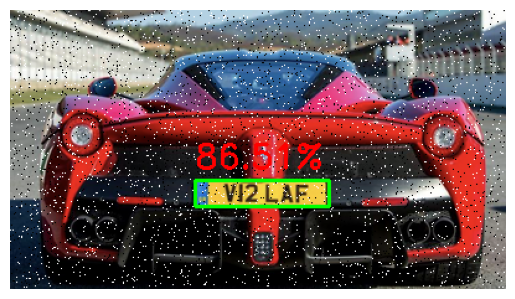

In [56]:
predict_and_plot('/content/drive/MyDrive/Gaussian_images/val/images/Cars182.png')